# Example: Finding overlap between surveys

In [1]:
%pylab inline
import numpy as np
import healpy as hp
import matplotlib.pyplot as pl
import hera_cc_utils as hera_cc
from matplotlib.colors import LogNorm

Populating the interactive namespace from numpy and matplotlib


## Simple start: plotting HERA stripe & GSM

First, let's just grab the global sky model (GSM) at 150 MHz to orient ourselves.

<Figure size 432x288 with 0 Axes>

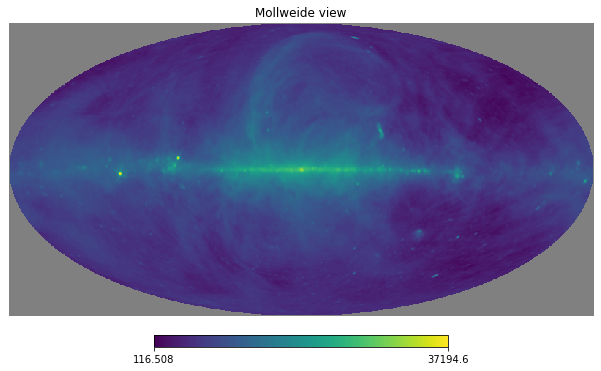

In [2]:
gsm = hera_cc.Map(data='gsm')
fig, ax, proj, img = gsm.plot_map(freq=150e6, projection='galactic', num=1,
    norm=LogNorm(1e2, 5e2))

Now let's make a healpix map of the HERA stripe. This is kind of overkill at the moment since it's easy to just overplot lines at constant declination, but it'll help establish how to do more quantitative comparisons of fields.

Let's use `nside=512`

In [3]:
# Convert nside to number of pixels
nside = 512
npix = hp.nside2npix(nside)

# Create angles in radians
theta, phi = hp.pix2ang(nside, np.arange(npix))

# Convert to RA and DEC in hours and degrees
deg_per_hr = 15.
ra = np.rad2deg(phi) / deg_per_hr
dec = np.rad2deg(0.5 * np.pi - theta)

# Setup a mask that tells us which pixels are in the HERA stripe.
hera_stripe = np.logical_and(dec >= -35, dec <= -25)

**NOTE:** You can recover this same result in two other ways now:
- `hera_stripe = hera_cc_utils.field_to_healpix(-35, -25)`.
- `hera_stripe = hera_cc.Map(data='hera')`

Just note that in the first case, the variable `hera_stripe` is an array, while in the second, it is a `hera_cc_utils.Map` instance.

With a mask in place that represents the HERA stripe, we can initialize an object that looks like any other via `hera_cc.Map`, we just need to specify that the input coordinate system is the celestial coordinate system, `C`:

In [4]:
hera = hera_cc.Map(data=hera_stripe, coords_in='C')

which we can now use to make a pretty uninteresting plot:

<Figure size 432x288 with 0 Axes>

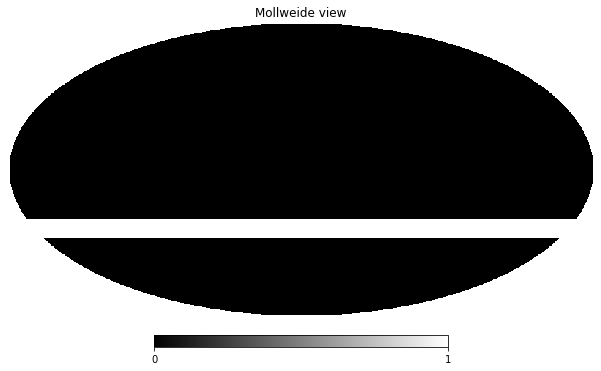

In [5]:
fig3, ax3, proj3, img3 = hera.plot_map(projection='equatorial', num=3, 
    cmap='binary_r')

To see the HERA stripe on top of the GSM in ecliptic coordinates, we can do (kind of hacky for now)

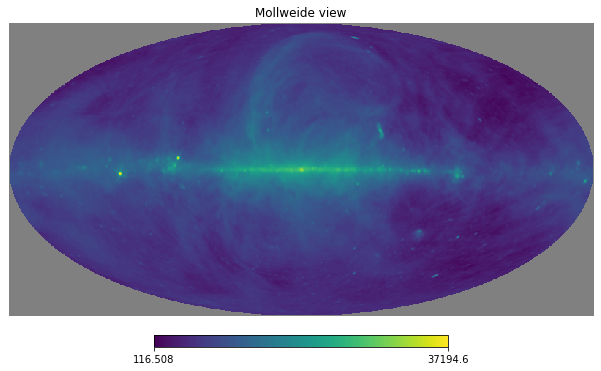

<Figure size 432x288 with 0 Axes>

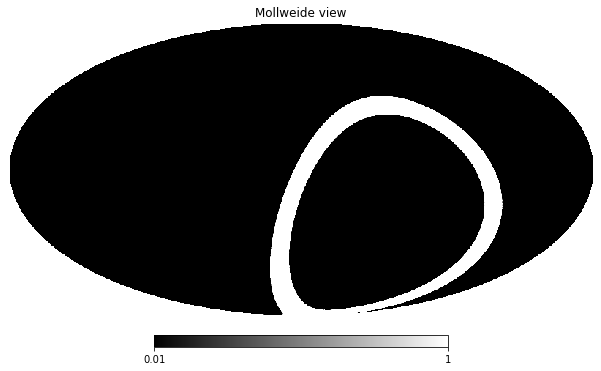

In [6]:
fig, ax, proj, img = gsm.plot_map(freq=150e6, projection='galactic', num=1,
    norm=LogNorm(1e2, 5e2))

# Set min=1e-2 because mollview doesn't like pixel values = 0
fig2, ax2, proj2, img2 = hera.plot_map(projection='galactic', cmap='binary_r', 
    min=1e-2)

Since I can't actually get mollview to overplot things at the moment...here's the rectilinear projection, which just uses `imshow`, with the HERA stripe overlaid using `alpha < 1`:

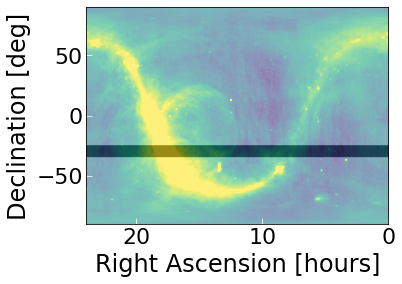

In [7]:
fig, ax, proj, img = gsm.plot_map(freq=150e6, projection='rectilinear', num=1,
    norm=LogNorm(1e2, 1e3))

fig2, ax2, proj2, img2 = hera.plot_map(projection='rectilinear', cmap='binary', ax=ax, alpha=0.4)

## Comparing to galaxy survey fields

We have the machinery to handle a few other surveys, namely, the planned high-latitude survey (HLS) for the Roman Space Telescope, and EUCLID deep fields. The exact footprints of these surveys aren't final, nor is their exact coverage necessarily public. However, we've got some pretty good placeholders, they just cannot be posted publicly or tracked in our repository. Contact Jordan or Adélie if you want to play with these files.

To load in the HLS footprint, you can do

In [8]:
roman_hls = hera_cc.Map(data='roman')

and for the EUCLID fields,

In [9]:
euclid_fornax = hera_cc.Map(data='euclid_fornax')
euclid_south = hera_cc.Map(data='euclid_south')

which we can then overplot with the GSM and HERA stripe:

(-55.0, 0.0)

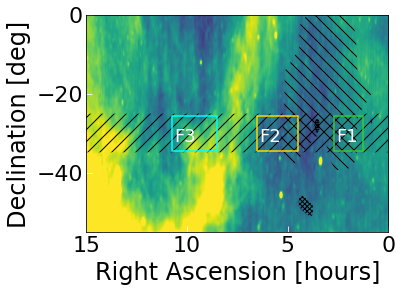

In [10]:
# Set the GSM at 150 MHz as the backdrop
fig, ax, proj, img = gsm.plot_map(freq=150e6, projection='rectilinear', num=1,
    norm=LogNorm(1e2, 5e2))

# Overplot cross-hatched regions for each survey
fig2, ax2, proj2, img2 = hera.plot_map(projection='rectilinear',  
    hatches='//', ax=ax, alpha=0)
fig3, ax3, proj3, img3 = roman_hls.plot_map(projection='rectilinear', ax=ax, 
    hatches='\\\\', alpha=0)
fig3, ax3, proj3, img3 = euclid_fornax.plot_map(projection='rectilinear', ax=ax, 
    hatches='ooooo', alpha=0)
fig4, ax4, proj4, img4 = euclid_south.plot_map(projection='rectilinear', ax=ax, 
    hatches='xxxxx', alpha=0)

# Overplot individual HERA fields as boxes.
lst_colors = ['limegreen', 'gold', 'cyan']
lst_cuts = [(1.25, 2.7), (4.5, 6.5), (8.5, 10.75)]
for i, lc in enumerate(lst_cuts):
    ax.fill_between([lc[0], lc[1]], -34.5, -25.5, facecolor='none',
        edgecolor=lst_colors[i],
        alpha=1, zorder=5, lw=1.5)
    ax.text(lc[1]-.1, -32, "F{}".format(i + 1), fontsize=18, c='w')

# Zoom-in a bit
ax.set_xlim(15, 0)
ax.set_ylim(-55, 0)

Looks like we've got overlap with the EUCLID Fornax field, but not EUCLID South.

## Computing the overlap in sky coverage between surveys

If we've got two maps with the same `nside`, computing the overlap should be pretty easy. Let's compute the overlap between HERA and the HLS.

First, let's get a healpix version of the HERA stripe with the same resolution as the Roman HLS:

In [11]:
hls = roman_hls.get_map()
nside = hp.npix2nside(hls.size)

# This is just a convenience routine to turn a constant DEC stripe into a healpix map.
hera_stripe = hera_cc.field_to_healpix(-35, -25, nside=nside)

In [12]:
# Each pixel is this many square degrees
pix = hp.nside2pixarea(nside, degrees=True)

As a sanity check, the total sky area of the HERA stripe in $\mathrm{deg}^2$ is

In [13]:
pix * hera_stripe.sum()

3008.0284244368218

or as a fraction of the sky

In [14]:
hera_stripe.sum() / float(hera_stripe.size)

0.07291666666666667

Since each survey map is just a mask of ones and zeros, where ones indicate pixels in the survey, we can just multiply to find the overlap region. We just need to be sure both maps are in the same coordinate system first. Since we made the HERA footprint as a constant DEC stripe, let's just retrieve the equivalent map for HLS:

In [15]:
overlap = roman_hls.get_map(projection='celestial') * hera_stripe

In [16]:
overlap.sum() * pix

504.11624664331964

In [17]:
# Check built-in routine
hera_cc.get_overlap_area(hls, hera_stripe)

527.0764091926127

Let's do some hacky plotting just for a visual sanity check here. First, we'll grab a bunch of maps and convert to galactic coordinates:

In [18]:
gal = gsm.get_map(freq=150e6, projection='galactic')
eu_fnx = euclid_fornax.get_map(projection='galactic')
eu_S = euclid_south.get_map(projection='galactic')

# Need to make a nside=512 version of HERA stripe for hacky plot
hera_stripe512 = hera_cc.field_to_healpix(-35, -25, nside=512)
hera = hera_cc.Map(data=hera_stripe512, coords_in='C')
# Interpolate HLS map to common resolution?

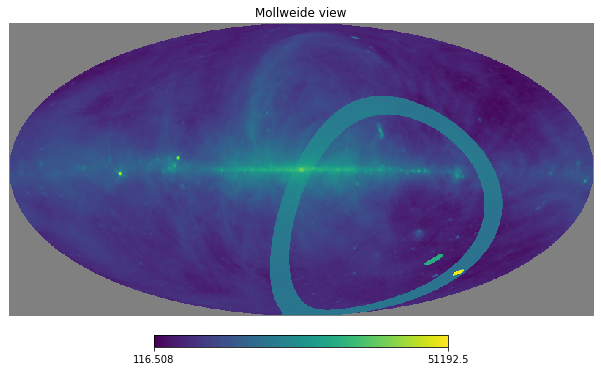

In [19]:
hp.mollview(gal + 5e4 * eu_fnx + 5e3 * eu_S 
                + 1e3 * hera.get_map(projection='galactic'),
               norm=LogNorm(1e2, 1e3))

As a sanity check, the Euclid South and Fornax fields should be $20$ and $10$ square degrees, respectively:

In [20]:
hera_cc.get_map_area(eu_S), hera_cc.get_map_area(eu_fnx)

(24.595881242252904, 10.011738192225748)

Lastly, if we want to plot individual HERA fields, defined by LST, we can do something like:

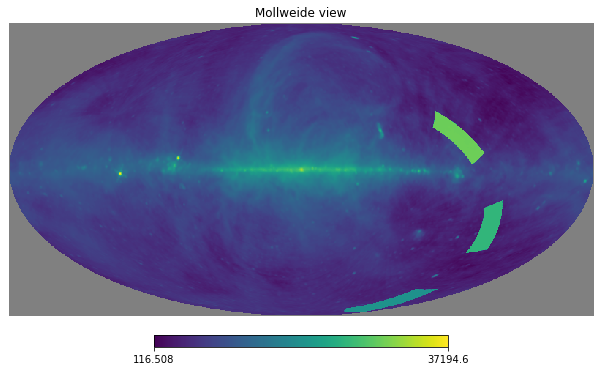

In [21]:
hera_fields = [hera_cc.field_to_healpix(-35, -25, ra_min=cut[0], ra_max=cut[1]) for cut in lst_cuts]
hera_fields_hp = [hera_cc.Map(data=field, coords_in='C').get_map(projection='galactic') for field in hera_fields]

hp.mollview(gal + hera_fields_hp[0] * 2e3 + hera_fields_hp[1] * 5e3 + hera_fields_hp[2] * 1e4,
               norm=LogNorm(1e2, 1e3))